In [134]:
import json
from fastf1.ergast import Ergast=
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.ticker import ScalarFormatter, PercentFormatter


ergast = Ergast(result_type='pandas')

with open("../data/season_info.json") as file:
    season_info = json.loads(file.read())
races_2024 = season_info["races"]
drivers = season_info["drivers"]
team_colours = season_info["team_colours"]

team_colours["RB"] = "#587B98"

font_files = font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

font = font_manager.FontProperties(
    family="Formula1", weight="normal", style="normal", size=16)

In [ ]:
number_of_races = 3

dfs = []

for i in range(1, number_of_races + 1): 
    pit_stops = ergast.get_pit_stops(season=2024, round=i)

    data = pit_stops.content[0]

    data["driverId"] = data["driverId"].str.title()

    data["driverId"] = data["driverId"].str.split("_").str[-1]

    data["race"] = i

    race_name = list(races_2024.keys())[i - 1]

    data["race name"] = race_name

    dfs.append(data)

pitstops = pd.concat(dfs, ignore_index=True)

surname_to_team = {info["Surname"]: info["Team"] for info in drivers.values()}

pitstops["team"] = pitstops["driverId"].map(lambda x: surname_to_team.get(x, None))


In [ ]:
pitstops['driver race average'] = pitstops.groupby(
    ['driverId', 'race'])['duration'].transform('mean')

pitstops['team race average'] = pitstops.groupby(
    ['team', 'race'])['duration'].transform('mean')

In [ ]:
pitstops

In [ ]:
team_pitstops = pitstops[[
    'race', 'race name', 'team', 'team race average']].drop_duplicates()
team_pitstops = team_pitstops.reset_index()

In [ ]:
team_pitstops 

In [ ]:
fastest_team_race_avg = team_pitstops.groupby('race')[
    'team race average'].min()

# Merge the fastest team race average back to the original DataFrame
team_pitstops = team_pitstops.merge(
    fastest_team_race_avg, on=['race'], suffixes=('', '_fastest'))

# Calculate the normalized values
team_pitstops['normalised'] = team_pitstops['team race average'] / \
    team_pitstops['team race average_fastest']

# Drop the helper column
team_pitstops.drop(
    columns=['team race average_fastest'], inplace=True)

In [90]:
team_pitstops

,index,race,race name,team,team race average,normalised
0,0,1,Bahrain,Haas F1 Team,0 days 00:00:27.942250,1.151237
1,1,1,Bahrain,Kick Sauber,0 days 00:00:37.873750,1.560421
2,2,1,Bahrain,Aston Martin,0 days 00:00:24.583000,1.012834
3,3,1,Bahrain,Alpine,0 days 00:00:26.616000,1.096595
4,4,1,Bahrain,Williams,0 days 00:00:28.493333333,1.173942
5,5,1,Bahrain,Mercedes,0 days 00:00:24.910333333,1.026320
6,6,1,Bahrain,Ferrari,0 days 00:00:24.271500,1.000000
7,8,1,Bahrain,Red Bull Racing,0 days 00:00:24.790000,1.021363
8,9,1,Bahrain,McLaren,0 days 00:00:24.786666666,1.021225
9,14,1,Bahrain,RB,0 days 00:00:24.856000,1.024082


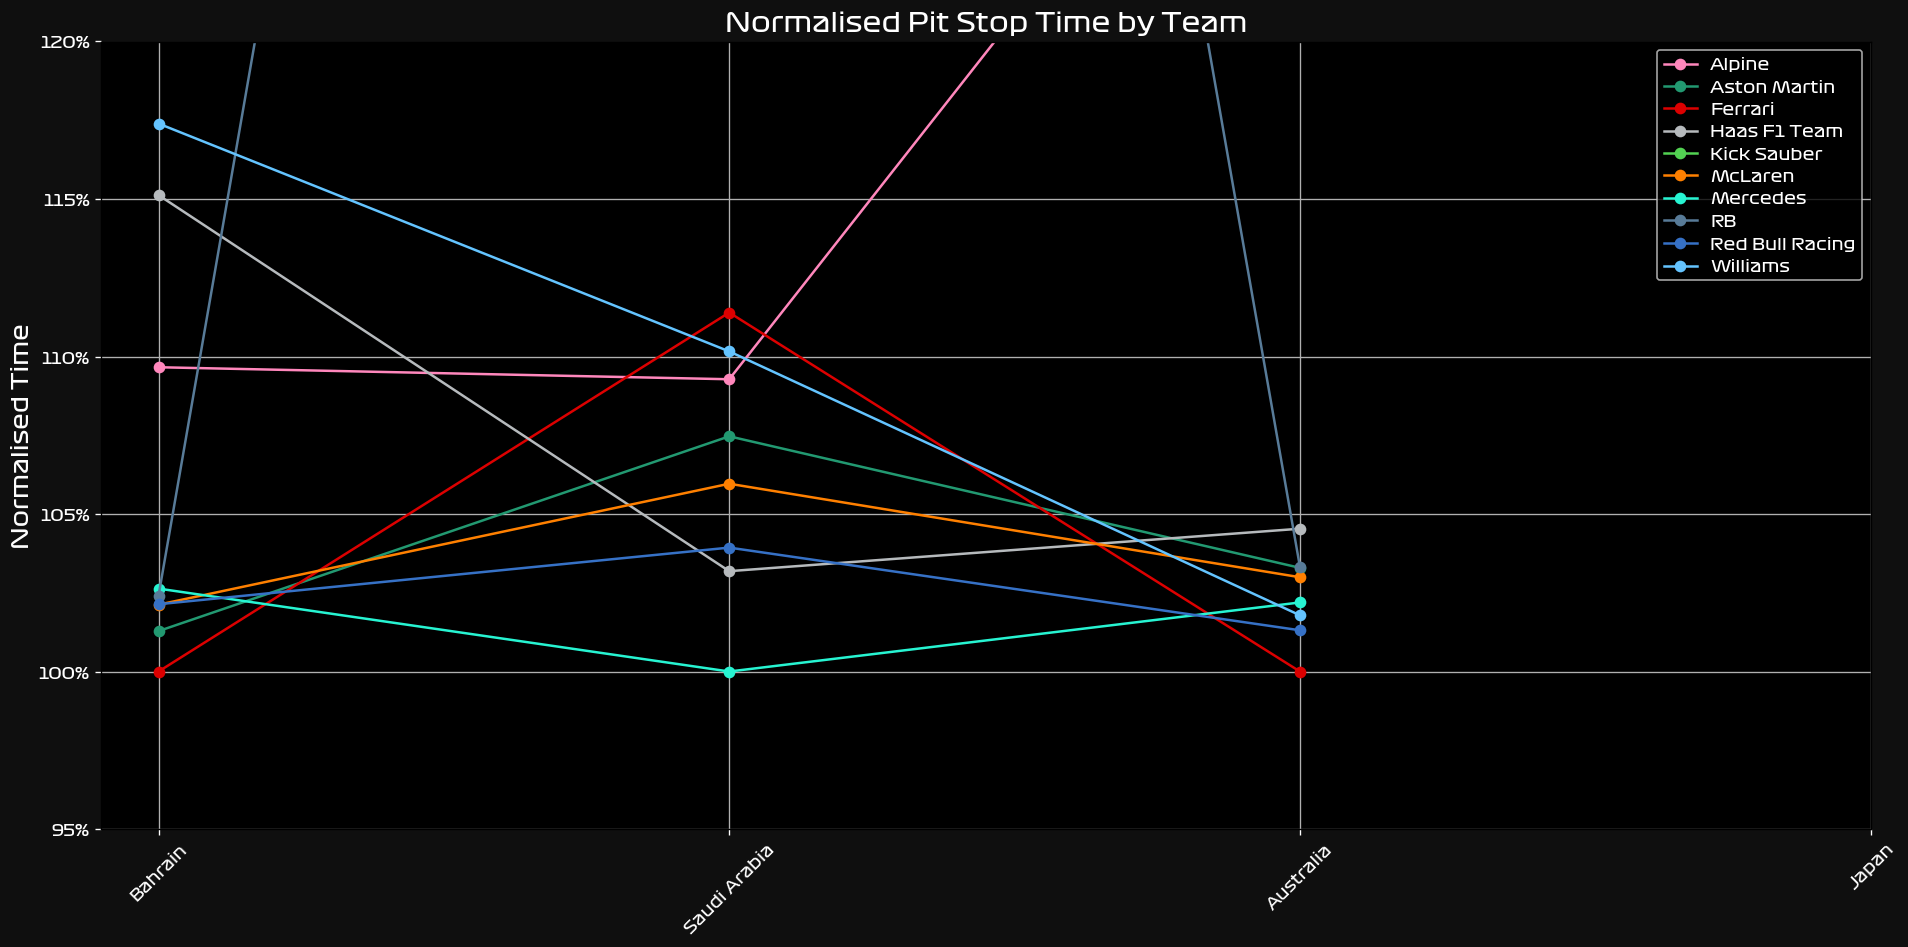

In [137]:
# Group by race and team, then calculate the mean of normalized times for each race and team
grouped_data = team_pitstops.groupby(['race', 'team'])[
    'normalised'].mean().unstack()


# Plot a line for each team

plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

plt.figure(figsize=(16, 8), dpi=120, facecolor="#0F0F0F")
plt.gca().set_facecolor("black")

for team, data in grouped_data.items():
    colour = team_colours.get(team, 'black')
    plt.plot(data.index, data.values, marker='o',
             linestyle='-', label=team, color=colour)

# Set the title and labels
plt.title('Normalised Pit Stop Time by Team', font="Formula1", fontsize=16)
plt.ylabel('Normalised Time', font="Formula1", fontsize=14)
plt.yticks(font="Formula1")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

plt.ylim(0.95, 1.2)

race_names = list(races_2024.keys())[:number_of_races + 1]
plt.xticks(range(1, len(race_names) + 1),
           race_names, rotation=45, color='white', font="Formula1")

# Add a legend
legend = plt.legend(loc='best', prop="Formula1")
plt.setp(legend.get_title(), color='white')  # Set legend title color
legend.get_frame().set_facecolor('black')  # Set legend background to black

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [102]:
race_names

['Bahrain', 'Saudi Arabia', 'Australia']